In [1]:
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch, time

import matplotlib.pyplot as plt
import numpy as np


# Transforms

In [2]:
from torchvision import transforms as T

TRAIN_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])

VAL_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


TEST_TRANSFORMERS = transforms.Compose([
    T.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # will help the model to work faster &
    #predi better by normalizing the data to -1, 0
    ])


In [3]:
# import splitfolders
# input_folder = './PlantVillage/'
# splitfolders.ratio(input_folder, output='./NewPlantVillageFolder', seed=24, ratio=(.7, .2, .1), group_prefix=None)

train_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/train/', transform=TRAIN_TRANSFORMERS)
val_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/val/', transform=VAL_TRANSFORMERS)
tes_data = torchvision.datasets.ImageFolder(root='./NewPlantVillageFolder/test/', transform=TEST_TRANSFORMERS)


In [4]:

train_data_loader = data.DataLoader(train_data, shuffle=True, batch_size=32, num_workers=4)
#we're doubling it by 2 on the val_ data_loader cuz we're not goint to calculate the grediant, 
# so we do not use as much as mimory as the train_data_loader
val_data_loader  = data.DataLoader(val_data, shuffle=False, batch_size=64, num_workers=4) 
test_data_loader = data.DataLoader(tes_data, shuffle=False, batch_size=64, num_workers=4)

print(len(train_data))
print(len(val_data))
print(len(tes_data))

print('====================')

print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

1506
430
216
48
7
4


In [5]:
images, labels = next(iter(train_data_loader))
images.shape

torch.Size([32, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
labels >>  tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


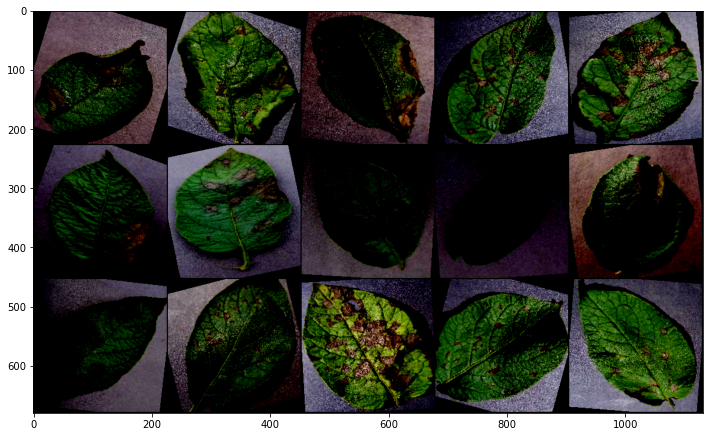

In [6]:
def show_transformed_images(dataset):
    loader = data.DataLoader(train_data, batch_size=15, shuffle=True)
    batch = next(iter(loader))
    images, targets = batch

    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    print(images.shape, targets)
    print('labels >> ', targets)
    
    
show_transformed_images(train_data_loader)

In [7]:
batch = next(iter(train_data_loader))
imgs, targets = batch
imgs.shape, targets

(torch.Size([32, 3, 224, 224]),
 tensor([1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 1,
         1, 1, 0, 0, 1, 0, 1, 1]))

# Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Step 2: Define the CNN architecture
#### Parameters
input_size = 3
num_classes = 3
num_epoch  = 3  
batch_size = 32
learning_rate = 0.01


class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        #self.dropout1 = nn.Dropout(0.25) I do not think we need drop out in this case
        
        #self.fc1 = nn.Linear(in_features=50176, out_features=32)
        #self.fc2 = nn.Linear(in_features=32, out_features=3)
        #self.fc1 = nn.Linear(in_features=16*64*64, out_features=3) # if the img size is (256, 256)
        self.fc2 = nn.Linear(in_features=16*56*56, out_features=3)  # if we resize it to (224, 224)

        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        #self.dropout1(x)
        
        #### Flatten ---> from 3d to 1d tensor
        #print('Three-d tensor', x.shape) # torch.Size([4, 16, 64, 64])
        #print('Three-d tensor', x.shape) torch.Size([32, 16, 56, 56])
        
        out = out.reshape(out.shape[0], -1)
        #print('One-d tensor', x.shape) #torch.Size([4, 65536])
        #print('One-d tensor', x.shape) #torch.Size([32, 50176])

        #out = self.fc1(out)
        out = self.fc2(out)
        return out
    
my_cnn = CNN()
my_cnn   

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=50176, out_features=3, bias=True)
)

# Loss, Optimizer

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_cnn.parameters(), lr=0.001)

# #################################################################

In [14]:
def validator_func(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0

    ##### Test validator_func will return the all the losses in every batch [in every 64]
    for images, labels in valid_loader:
        output = model(images)
        loss = loss_function(output, labels)
        loss_total += loss.item()
    return loss_total / len(valid_loader)

In [15]:
def tester_func(device, model, test_loader):

    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:

            output = model(images)
            _, predicted = torch.max(output, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy:', correct / total)

In [16]:
# Train
def trainer_func(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    
    # Early stopping
    last_loss = 100 ##### it does not mater what number you asign to it, it'll be reassigned on the bottom
    num_time_withNotImprovment = 2
    trigger_times = 0
    

    min_val_loss = np.inf
    epochs_no_improve = 0
    n_epochs_stop = 3
    early_stop = False
    patience = 2 # patience (If it is set to 2, the training will stop if loss drops 2 times continuously)
    
    for epoch in range(1, epochs+1):
        print(f"##################################################################### Epoch {epoch} ")
        model.train()

        for ix, (images, labels) in enumerate(train_loader, 1):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(images)
            train_loss = loss_function(output, labels)
            train_loss.backward()
            optimizer.step()

            # Show progress
            if ix % 20 == 0 or ix == len(train_loader):
                print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, ix, len(train_loader), train_loss.item()))
                
        ###############  Early stopping at every iteration
        current_val_loss = validator_func(model, device, valid_loader, loss_function)
        print(' ============ My Avarage current_val_loss per epoch:', current_val_loss)
        
        if current_val_loss > last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model
        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_val_loss
        
        ############### Early stopping at every epoch
        # If the validation loss is at a minimum
#         if current_val_loss < min_val_loss: 
#             epochs_no_improve = 0
#             min_val_loss = current_val_loss
#         else:
#             epochs_no_improve += 1

#         if epoch > 6 and epochs_no_improve == n_epochs_stop:
#             print('Early stopping..!' )
#             early_stop = True
#             break
#         else:
#             continue
#         break

    return model


In [17]:
def main():
    
    # GPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print('Device state:', device)

    # Train
    model = trainer_func(
                      device, 
                      my_cnn, epochs=12, 
                      optimizer=optimizer, 
                      loss_function=loss_function, 
                      train_loader=train_data_loader, 
                      valid_loader=val_data_loader  
                     )
    
    tester_func(device=device, model=my_cnn, test_loader=test_data_loader)

if __name__ == '__main__':
    main()

Device state: cpu
##################################################################### Epoch 1 
[1/12, 20/48] loss: 0.52387697
[1/12, 40/48] loss: 0.34686485
[1/12, 48/48] loss: 2.0308197
 ============ My Avarage current_val_loss per epoch: 0.1946239173412323
trigger times: 0
##################################################################### Epoch 2 
[2/12, 20/48] loss: 0.27030012
[2/12, 40/48] loss: 0.10491087
[2/12, 48/48] loss: 0.036572501
 ============ My Avarage current_val_loss per epoch: 0.16283081897667476
trigger times: 0
##################################################################### Epoch 3 
[3/12, 20/48] loss: 0.38258129
[3/12, 40/48] loss: 0.093438946
[3/12, 48/48] loss: 0.12407649
 ============ My Avarage current_val_loss per epoch: 0.15399500621216639
trigger times: 0
##################################################################### Epoch 4 
[4/12, 20/48] loss: 0.12205843
[4/12, 40/48] loss: 0.22436984
[4/12, 48/48] loss: 0.0023115012
 ============ My Avara